In [5]:
import nengo

import numpy as np
import matplotlib.pyplot as plt
from nengo.processes import WhiteSignal

In [ ]:
model = nengo.Network(label="Learning", seed=0)

with model:
    pre = nengo.Ensemble(50, dimensions=1, label="Pre")
    post = nengo.Ensemble(50, dimensions=1, label="Post")

    error = nengo.Ensemble(100, dimensions=1, label="Learning Error")
    actual_error = nengo.Node(size_in=1, label="Actual Error")

    # channel
    # nengo.Connection(pre, actual_error, transform=-1)
    # nengo.Connection(pre, error, transform=-1, synapse=0.02)

    nengo.Connection(post, actual_error, transform=1)
    nengo.Connection(post, error, transform=1, synapse=0.02)

    # Learn the square function
    nengo.Connection(pre, actual_error, function=lambda x: x**2, transform=-1)
    nengo.Connection(pre, error, function=lambda x: x**2, transform=-1)

    conn = nengo.Connection(
        pre,
        post,
        function=lambda x: np.random.random(1),
        solver=nengo.solvers.LstsqL2(weights=True),
    )

    # Adding the learning rule to the connection
    conn.learning_rule_type = {
        "my_pes": nengo.PES(),
        "my_bcm": nengo.BCM(learning_rate=1e-10),
    }

    error_conn = nengo.Connection(error, conn.learning_rule["my_pes"])

    stim = nengo.Node(WhiteSignal(30, high=10), label="Input")  # RMS = 0.5 by default
    nengo.Connection(stim, pre, synapse=0.02)  # Connect the input to the pre ensemble

    # Function to inhibit the error population after 15s
    def inhib(t):
        return 2.0 if t > 15.0 else 0.0

    # Connecting inhibit population to error population
    inhibit = nengo.Node(inhib, label="Inhibit")
    nengo.Connection(
        inhibit, error.neurons, transform=[[-3]] * error.n_neurons, synapse=0.01
    )

    in_probe = nengo.Probe(pre, synapse=0.01)
    out_probe = nengo.Probe(post, synapse=0.01)
    err_probe = nengo.Probe(actual_error, synapse=0.01)

In [12]:
sim = nengo.Simulator(model)

with sim:
    sim.run(30.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

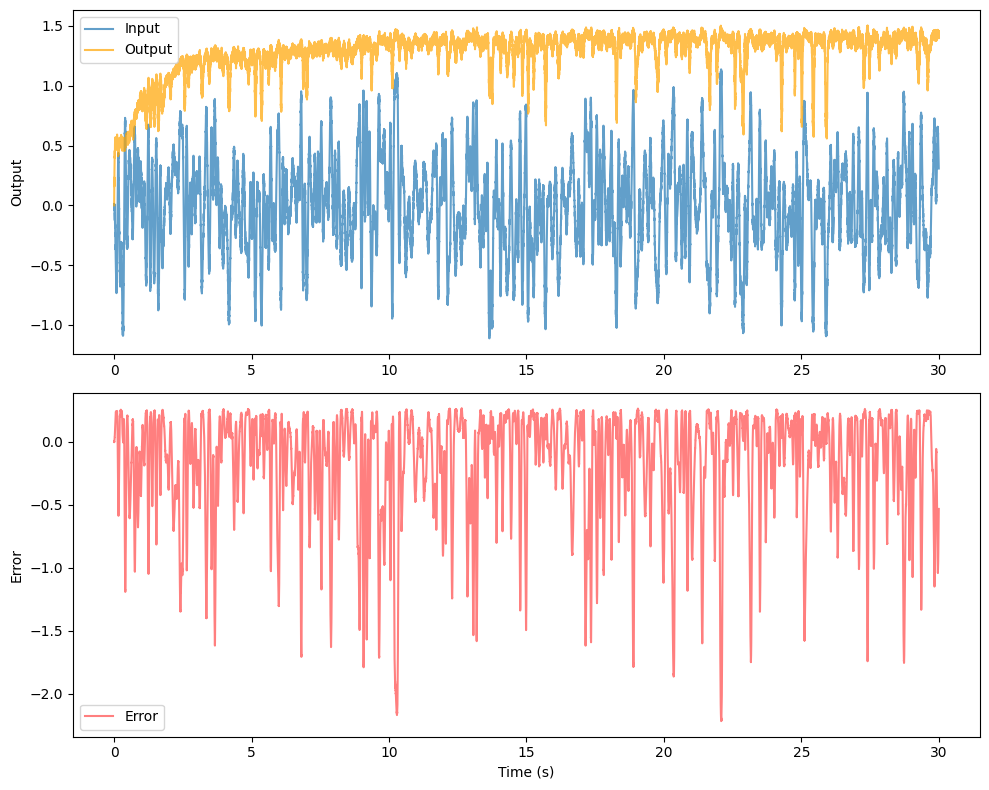

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(sim.trange(), sim.data[in_probe], label="Input", alpha=0.7)
ax[0].set_ylabel("Input")
ax[0].plot(sim.trange(), sim.data[out_probe], label="Output", color="orange", alpha=0.7)
ax[0].set_ylabel("Output")
ax[0].legend()
ax[1].plot(sim.trange(), sim.data[err_probe], label="Error", color="red", alpha=0.5)
ax[1].set_ylabel("Error")
ax[1].set_xlabel("Time (s)")
ax[1].legend()
plt.tight_layout()
plt.show()